# SHAP metric for binary classification of text based model

The notebook will train an SMS spam detection model, generate local explanations using SHAP partition explainer and provide insights into the model behaviour.

### Contents
- [Setup](#Setup)
- [Model building and evaluation](#model)
- [OpenScale configuration](#openscale)
- [Compute SHAP explanations](#shap)
- [Visualize the explanations](#visualize)

**Note:** This notebook requires service credentials of Watson OpenScale.

## Setup

### Package Installation

In [ ]:
!pip install --upgrade pyspark==3.3.1 | tail -n 1
!pip install --upgrade ibm-watson-openscale --no-cache | tail -n 1
!pip install --upgrade ibm-metrics-plugin --no-cache | tail -n 1
!pip install matplotlib==3.2.2

**Action: Restart the kernel!**

### Configure Credentials

In [2]:
import warnings
warnings.filterwarnings("ignore")

Provide your IBM Watson OpenScale credentials in the following cell:

In [3]:
WOS_CREDENTIALS = {
    "url": "<cluster url>",
    "username": "",
    "password": "",
    "instance_id": "<service instance id>"
}


## Model building and evaluation <a name="model"></a>

In this section you will learn how to train Random Forest Classifier model, run prediction and evaluate its output.

### Load the training data from github

In [ ]:
!rm SMSSpam.csv
!wget https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/spam_detection/SMSSpam.csv -O SMSSpam.csv

In [4]:
import numpy as np
import pandas as pd

training_data_file_name = "SMSSpam.csv"
data_df = pd.read_csv(training_data_file_name)

### Explore data

In [5]:
data_df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
print("Columns: ", list(data_df.columns))
print("Number of columns: ", len(data_df.columns))

Columns:  ['label', 'text']
Number of columns:  2


In [7]:
print("Number of records: ", data_df.label.count())

Number of records:  5572


In [8]:
target_count = data_df.groupby("label")["label"].count()
target_count

label
ham     4825
spam     747
Name: label, dtype: int64

### Create a model

In this section you will learn how to:

- Prepare data for training a model
- Create machine learning pipeline
- Train a model
- Evaluate a model

#### Import required libraries

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [9]:
features = ["text"]
print("features : ", features)
X = data_df["text"]
y = data_df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123)

features :  ['text']


#### Preparing the pipeline


In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

model = Pipeline([("vect", CountVectorizer(lowercase=True, stop_words="english")),
                 ("tfidf", TfidfTransformer()), ("clf", RandomForestClassifier())])


#### Train a model


In [11]:
model = model.fit(X_train, y_train)

#### Evaluate the model

In [12]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, model.predict(X_test))

0.9775784753363229

## Openscale Configuration <a name="openscale"></a>

Import the necessary libraries and set up OpenScale Python client.

In [13]:
from ibm_watson_openscale import APIClient as OpenScaleAPIClient
from ibm_cloud_sdk_core.authenticators import CloudPakForDataAuthenticator

authenticator = CloudPakForDataAuthenticator(
    url=WOS_CREDENTIALS["url"],
    username=WOS_CREDENTIALS["username"],
    password=WOS_CREDENTIALS["password"],
    disable_ssl_verification=True
)

client = OpenScaleAPIClient(
    service_url=WOS_CREDENTIALS["url"],
    service_instance_id=WOS_CREDENTIALS["instance_id"],
    authenticator=authenticator
)

client.version

'3.0.34'

## Compute SHAP explanations <a name="shap"></a>

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions. See [paper](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) for technical details of the algorithm.

The Shapley value is the average marginal contribution of a feature value across all possible feature coalitions.

SHAP assigns each feature an importance value for a particular prediction which is called SHAP value. The SHAP values of all the input features will always sum up to the difference between baseline (expected) model output and the current model output for the prediction being explained.

### Prepare input to compute SHAP explanations

#### Create configuration for computing the SHAP metric

Set the below properties in the configuration

- **problem_type** : The model problem type. Possible values are 'binary', 'multiclass'
- **input_data_type**: The input data type. Supported value is 'unstructured text'
- **feature_columns**: The list of feature columns
- **explainability**: The expainability metrics configuration


In [14]:
from ibm_metrics_plugin.common.utils.constants import ExplainabilityMetricType, ProblemType, InputDataType, MetricGroupType
from ibm_metrics_plugin.metrics.explainability.entity.constants import ShapAlgorithm
configuration = {
    "configuration": {
        "problem_type": ProblemType.BINARY.value,
        "input_data_type": InputDataType.TEXT.value,
        "feature_columns": features,
        MetricGroupType.EXPLAINABILITY.value: {
            "metrics_configuration": {
                ExplainabilityMetricType.SHAP.value: {
                    "algorithm": ShapAlgorithm.PARTITION.value
                }
            }
        },

    }
}

#### Define the scoring function

The scoring function will be used to score against the model to get the probability and prediction values. The scoring function should take a pandas dataframe as input and return probability and prediction values.


In [15]:
def scoring_fn(data):
    data = data["text"]
    return model.predict_proba(data), model.predict(data)

In [16]:
test_df = pd.DataFrame(X_test, columns=["text"])

### Compute explanations

Compute the explanations for the test data. The test data could be a spark dataframe or pandas dataframe. Here we use a pandas dataframe.

In [ ]:
metrics_result = client.ai_metrics.compute_metrics(spark=None,
                                         configuration=configuration,
                                         data_frame=test_df[150:200],
                                         scoring_fn=scoring_fn)

## Visualize the explanations <a name="visualize"></a>

### Convert metrics result to shap explanations object

Convert the metrics result dict to shap explanations object, which can be used for plotting the explanations.

The **class_labels** are mandatory for bar plots

In [ ]:
shap_explanations=client.ai_metrics.transform_result(metrics_result=metrics_result, 
                                                     metric_group_type=MetricGroupType.EXPLAINABILITY.value, 
                                                     metric_type=ExplainabilityMetricType.SHAP.value,
                                                     input_data_type = InputDataType.TEXT.value,
                                                     class_labels = ["ham","spam"])

In [ ]:
shap=shap_explanations.get("shap")
shap.initjs()

In [23]:
local_explanations = shap_explanations.get("local")

### Get local explanation for a single record.

In [24]:
import sys
import io
stdout_saved = sys.stdout  
sys.stdout = io.StringIO()

In [ ]:
shap.plots.text(local_explanations[5])

In [ ]:
shap.plots.text(local_explanations[7])

### Multiple instance text plots

Shows plots for different input instances

In [ ]:
shap.plots.text(local_explanations[29:31])
sys.stdout = stdout_saved 

### Summarizing text explanations

These plots provide global summaries of the impact of tokens over multiple instances.

Here we are averaging over a few examples. To get a better summary you would want to increase the number of examples in the dataset.

The below graphs show the impacts of the tokens for classes "ham" and "spam" respectively.

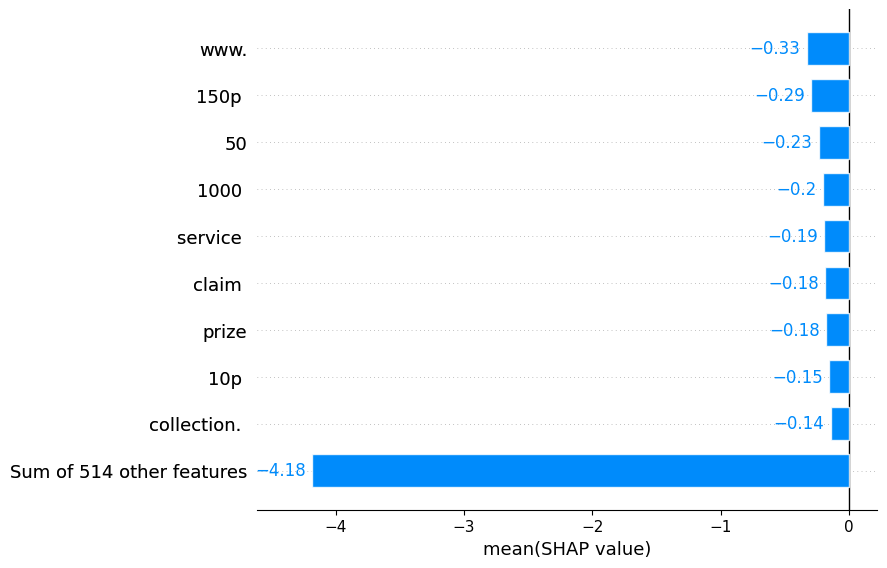

In [28]:
shap.plots.bar(local_explanations[:,:,"ham"].mean(0))

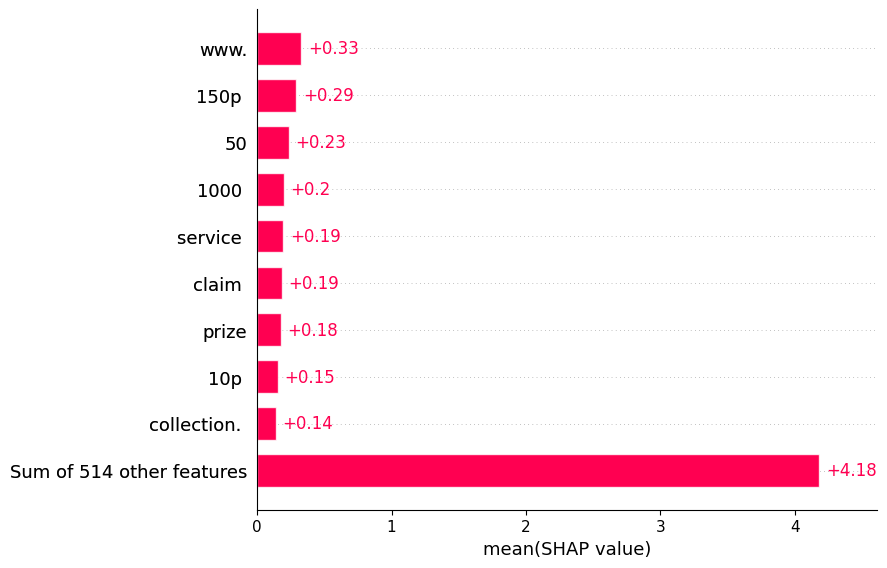

In [29]:
shap.plots.bar(local_explanations[:, :,"spam"].mean(0))